In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import zipfile
from google.colab import files
import matplotlib.pyplot as plt

In [3]:
zip_file_path = '/content/Image-Classification-Transfer-Learning-master.zip'
extract_dir = '/content/Image-Classification-Transfer-Learning-master'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [4]:
dataset_dir = os.path.join(extract_dir, 'Image-Classification-Transfer-Learning-master', 'Dataset')
train_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1554 images belonging to 20 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.jpg', '.png'))]

In [7]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

In [8]:
test_images = [preprocess_image(path) for path in test_image_paths]
test_images = tf.concat(test_images, axis=0)

In [9]:
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(20, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 60,450,324 (230.60 MB)

 Trainable params: 60,306,580 (230.05 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=train_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.5528 - loss: 1.7495 - val_accuracy: 0.9054 - val_loss: 0.3788
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9234 - loss: 0.2813 - val_accuracy: 0.9492 - val_loss: 0.1892
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9565 - loss: 0.1531 - val_accuracy: 0.9846 - val_loss: 0.0575
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9683 - loss: 0.1325 - val_accuracy: 0.9665 - val_loss: 0.1298
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9646 - loss: 0.1287 - val_accuracy: 0.9762 - val_loss: 0.0942
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9581 - loss: 0.1217 - val_accuracy: 0.9311 - val_loss: 0.2730
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9766 - loss: 0.0795 - val_accuracy: 0.9762 - val_loss: 0.0981
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9722 - loss: 0.1202 - val_accuracy: 0.9743 - val_loss: 0.1060
E

In [12]:
loss, accuracy = model.evaluate(train_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - accuracy: 0.9715 - loss: 0.1033
Test Loss: 0.11763213574886322
Test Accuracy: 0.9678249955177307


In [13]:
predictions = model.predict(test_images)

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 969ms/step


In [14]:
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]

In [15]:
for image_path, label in zip(test_image_paths, predicted_labels):
    print(f"Image: {image_path}, Predicted label: {label}")

Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_845.jpg, Predicted label: bear
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1406.jpg, Predicted label: bear
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_121.jpg, Predicted label: bear
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_880.jpg, Predicted label: bear
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1706.jpg, Predicted label: bear
Image: /content/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1228.jpg, Predicted label: calculator
Image: /content/Image-Classification-Transfer-Learning-

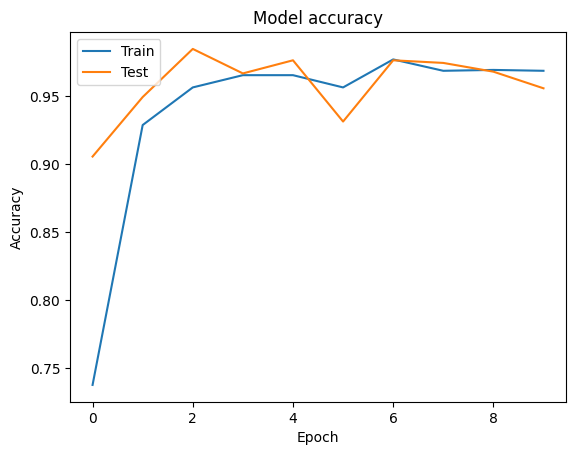

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

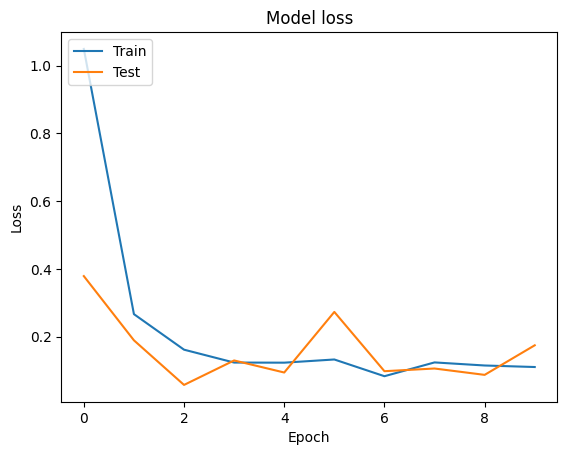

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()